# Grade: /100 pts
# Assignment 10: FATE Machine Learning

## Student ID: 251012214

In this coursework, we will study how to make a complex non-linear model more interpretable and we will study any fairness issues that may arise when using AI models to solve organizational problems.

Our problem will be graduate admission,  we'll create a model to predict if a person would be accepted the master program they applied for. The following questions first develop a model, then we study how to make it more interpretable, and finally, we discuss any fairness issues that arise.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score
#!pip install shap
from xgboost import XGBClassifier
import shap
seed = 0

For this assignment, we will use a graduate admission dataset. For further information about the data, refer to: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?resource=download&select=Admission_Predict.csv

**Variables**

1. GRE Scores ( out of 340 )
2. TOEFL Scores ( out of 120 )
3. University Rating ( out of 5 )
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
5. Undergraduate GPA ( out of 10 )
6. Research Experience ( either 0 or 1 )
7. Chance of Admit ( ranging from 0 to 1 )

# Part 1: Data preprocessing and model construction (20 pts)

**Task 1:** Load the data

**Task 2:** Create the target column as 1 if Change of Admit is >0.5 and 0 otherwise

**Task 3:** Drop Chance of Admit, Serial No. and University Rating

**Task 4:** Keep only rows with CGPA values between 8 and 9

**Task 5:** Save the shape in the variable df_shape and print it

**Written question:** Is this dataset imbalanced?

In [2]:
csv = pd.read_csv("/content/Admission_Predict.csv");
target = []
for i in csv.iloc[:,8]:
  dif = i - 0.5
  if dif > 0:
    target.append(1)
  else:
     target.append(0)
csv["target"] = target
data = csv.drop(csv[(csv['CGPA'] < 8) | (csv['CGPA'] > 9)].index, axis = 0)
data = data.drop(labels = csv.columns[[0,3,8]],axis = 1 ).reset_index(drop=True)
df_shape = data.shape
print(df_shape)
print("Post Trim")
label_counts = data["target"].value_counts()
print(label_counts)
print("Pre Trimmed ")
print(csv["target"].value_counts())

(277, 7)
Post Trim
1    267
0     10
Name: target, dtype: int64
Pre Trimmed 
1    461
0     39
Name: target, dtype: int64


### Answer:
The data is unbalanced before and after the trim.

## Model Construction (30 pts)

**Task 1:** Using all features , split the dataset into training and test sets with `test_size=0.3` and `random_state=0`. (For all later settings, work with this random seed). 

**Task 2:** Construct an xgboost model with the best of the following parameters: 'n_estimators': [50,100,150,250, 300, 350], 'max_depth': [3, 4, 5], 'learning_rate' : [0.001, 0.01, 0.1]. Correctly set the argument `scale_pos_weight`. Check the documentation if needed.

Report the best parameters you found. Save them in a dictionary call best_parameters

**Task 3:** fit the model over the full data using the best parameters you found, plot the roc and report the auc score.

In [88]:
y = data["target"]
X = data.drop(labels= data.columns[-1],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)
param = {
  'n_estimators': [50,100,150,250, 300, 350],
  'max_depth': [3, 4, 5],
  'learning_rate' : [0.001, 0.01, 0.1]
}
grid_cv = GridSearchCV(XGBClassifier(scale_pos_weight=label_counts[0]/label_counts[1]), param_grid = param, n_jobs=-1)
grid_cv.fit(X_train, y_train);
best_parameters = grid_cv.best_params_

AUC Score is  0.8658536585365854


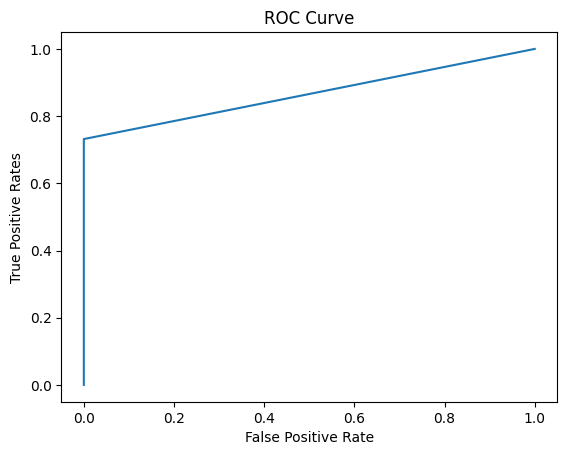

In [90]:
classifier = XGBClassifier(learning_rate= 0.001, max_depth= 3, n_estimators= 50, random_state = seed,scale_pos_weight=label_counts[0]/label_counts[1])
model = classifier.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)
score = roc_auc_score(y_test,y_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test,y_prob[:,1])
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rates")
print("AUC Score is ", score)

# Part 2: Feature importance and Interpretability (50 pts)

## Feature Importance (11 pts)

In this part, we compare the variable importance constructed by mean-gini and mean-shap values.

**Task 1:** Plot the variable importance plot by Entropy. 

**Task 2:** Plot the variable importance plot by mean-shap value. 

**Task 3:** Discuss the differences between the variables importance and why do you think it happens. 

Text(0.5, 1.0, 'Variable Importance by Entropy')

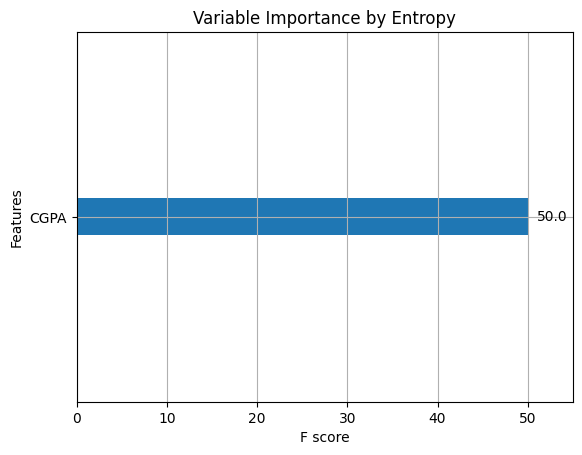

In [91]:
classifier = XGBClassifier(objective='binary:logistic', random_state=seed, learning_rate= 0.001, max_depth= 3, n_estimators= 50, scale_pos_weight=label_counts[0]/label_counts[1])
model = classifier.fit(X_train, y_train)
plot_importance(model)
plt.title("Variable Importance by Entropy")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Text(0.5, 1.0, 'Variable Importance by Mean SHAP Value')

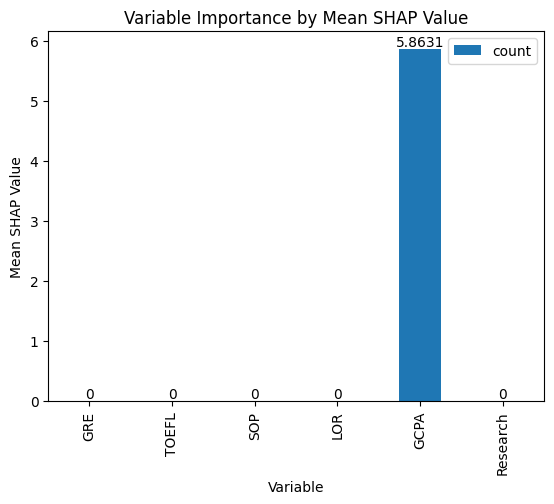

In [37]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)
x = shap_values.T
shap_feature_imp = []
labels = ["GRE", "TOEFL", "SOP", "LOR", "GCPA", "Research"]
c = 0
for i in x:
  shap_feature_imp.append( {"count":abs(sum(i)),"variables":labels[c]})
  c += 1
imp = pd.DataFrame(shap_feature_imp)
ax = imp.plot(kind="bar", x = "variables", y = "count")
for i in ax.containers:
    ax.bar_label(i)
plt.xlabel('Variable')
plt.ylabel('Mean SHAP Value')
plt.title('Variable Importance by Mean SHAP Value')

###Answer:
I think since theres gpa is such a broadly important factor that it is the only one that maters for the entropy and it takes outs 50 percent of the randomness in the SHAP plot however it adds importance of almost 6 features as its highly corrolated to the rest and only one being given importance to

## Understanding and interpreting using SHAP values (39 pts)

**Task 1:** explain the model's predictions using SHAP for the first, third and fourth cases in the dataset. What can you conclude from the feature contribution plot? 

**Task 2:** Summarize the effects of all features by using a beeswarm plot. Report the first 3 features and interpret the results. 

**Task 3 :** For each of the variables "GRE Score" and "CGPA", create a Shap-value dependence scatter plot to show the effect of the single feature across the whole dataset.

In [83]:
explainer = shap.TreeExplainer(model,X)
shap_values = explainer.shap_values(X)
print(shap_values[[0,2,5],4])
print(model.predict(X)[[0,2,5]])
print(X[0:4])
print(y[[0,2,5]])

[ 0.02764937  0.02764937 -0.04511213]
[1 1 0]
   GRE Score  TOEFL Score  SOP  LOR   CGPA  Research
0        324          107  4.0   4.5  8.87         1
1        316          104  3.0   3.5  8.00         1
2        322          110  3.5   2.5  8.67         1
3        314          103  2.0   3.0  8.21         0
0    1
2    1
5    0
Name: target, dtype: int64


1. it predicts correctly as the gpa has a positive weight and its the only factor taken into acount so it predicts positively.

<Axes: >

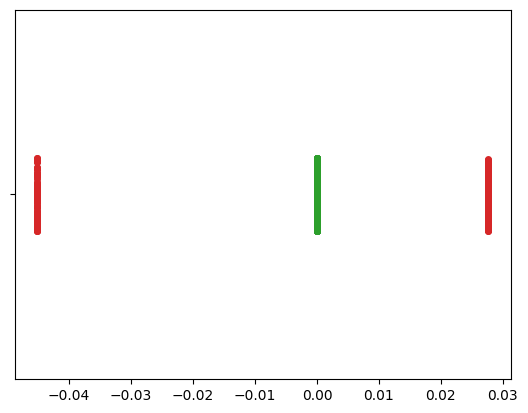

In [78]:
sns.stripplot(x=explainer.shap_values(X).T[0])
sns.stripplot(x=explainer.shap_values(X).T[1])
sns.stripplot(x=explainer.shap_values(X).T[2])
sns.stripplot(x=explainer.shap_values(X).T[4])





1. Again the first three features hold no effect on the model while the fifth feature CGPA hold massive weight in positive or negative

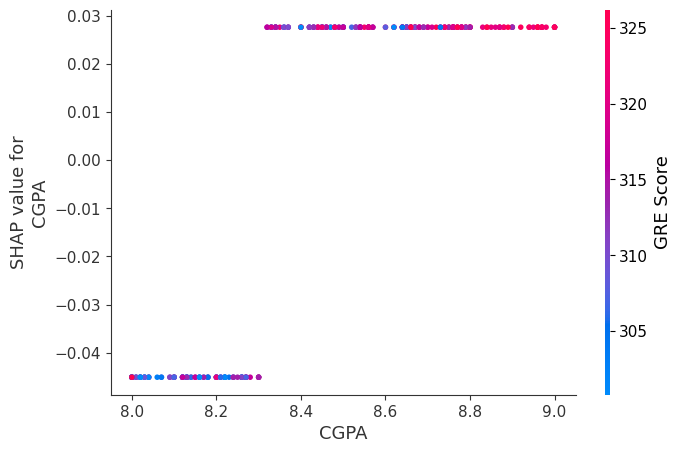

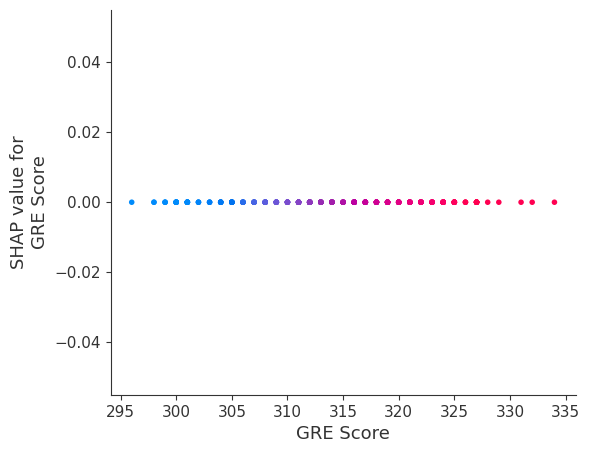

In [87]:
shap.dependence_plot(4, shap_values, X) 
shap.dependence_plot(0, shap_values, X) 

# create a Shap-value dependence scatter plot for "CGPA"
# shap.plots.scatter(explainer, X['CGPA'])